# Exp4: Backdoor Attacks on DNN

# Import Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mmcv import Config
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch

from tools.data_poison import data_poison
from tools.test import test
from modules.vgg import vgg13_bn

%load_ext autoreload
%autoreload 2 

# Visualize Poisoned Training Dataset

Files already downloaded and verified
Files already downloaded and verified


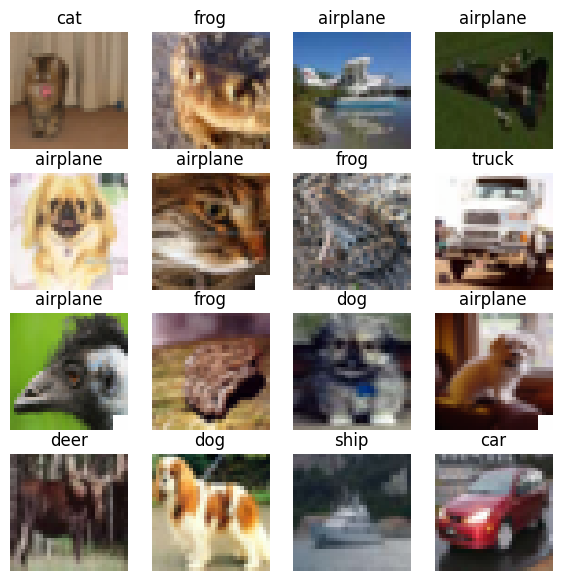

In [5]:
cfg = Config.fromfile('./configs/vgg13_bn.py')

classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(16):
    img, label = cfg.dset_train[i]
    img = img.numpy().transpose(1, 2, 0)
    img = (img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])) * 255
    
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.title(classes[label])
    plt.imshow(img.astype('uint8'))
    

# Test Clean Data Accuracy and  Attack Success Rate
Load the clean test dataset and poisoned test dataset.

In [2]:
batch_size = 128

transform_test = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

clean_dset_test = dset.CIFAR10('./datasets', train=False, download=True, transform=transform_test)
loader_clean_test = DataLoader(clean_dset_test, batch_size=batch_size, num_workers=2)

poisoned_dset_test = data_poison(clean_dset_test, 1, 0, combine=False)
loader_poisoned_test = DataLoader(poisoned_dset_test, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


Have a look at the poisoned test dataset.

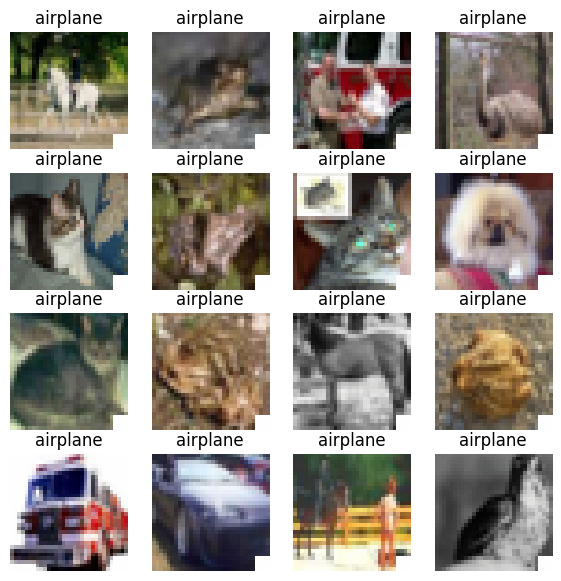

In [7]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(16):
    img, label = poisoned_dset_test[i]
    img = img.numpy().transpose(1, 2, 0)
    img = (img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])) * 255
    
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.title(classes[label])
    plt.imshow(img.astype('uint8'))
    

In [9]:
ratio = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
CDA = list()
ASR = list()
vgg13_bn_ = vgg13_bn(num_classes=10)
for r in ratio:
    # load pretrained weights
    name = str(r).replace('.', '')
    pth_file = './pth_files/' + name + '.pth'
    vgg13_bn_.load_state_dict(torch.load(pth_file))
    
    # test
    cda = test(loader_clean_test, vgg13_bn_, verbose=False, cls_acc=False)
    asr = test(loader_poisoned_test, vgg13_bn_, verbose=False, cls_acc=False)
    
    CDA.append(cda)
    ASR.append(asr)
    print('ratio:%.1f  cda:%.2f%%  asr:%.2f%%' % (r, 100*cda, 100*asr))
    

ratio:0.0  cda:89.11%  asr:1.52%
ratio:0.1  cda:88.47%  asr:97.91%
ratio:0.2  cda:88.40%  asr:98.63%
ratio:0.3  cda:88.18%  asr:98.68%
ratio:0.4  cda:87.94%  asr:98.34%
ratio:0.5  cda:87.83%  asr:99.72%
ratio:0.6  cda:88.07%  asr:98.78%
ratio:0.7  cda:87.77%  asr:99.43%
ratio:0.8  cda:87.73%  asr:99.04%
ratio:0.9  cda:87.34%  asr:99.28%
ratio:1.0  cda:87.53%  asr:99.87%


Visualize.

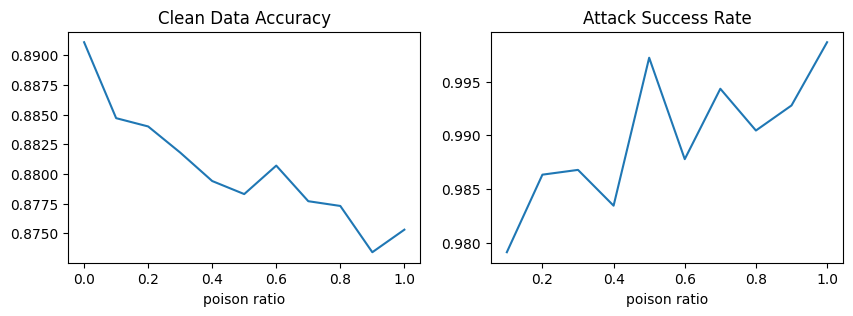

In [10]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('Clean Data Accuracy')
plt.xlabel('poison ratio')
plt.plot(ratio, CDA, '-')

plt.subplot(1, 2, 2)
plt.title('Attack Success Rate')
plt.xlabel('poison ratio')
plt.plot(ratio[1:], ASR[1:], '-')

plt.show()